# Mandelbrot on all accelerators

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Python "for" loops: imperative

In [2]:
def run_python(height, width, maxiterations=20):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.full(c.shape, maxiterations, dtype=np.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

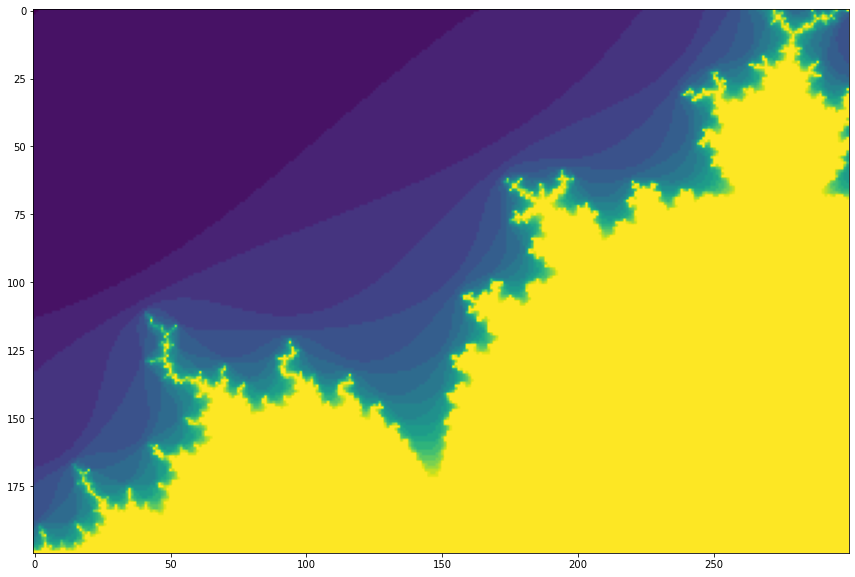

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_python(200, 300));   # running on 100× fewer pixels than all other tests (low resolution)

In [4]:
%%timeit -o
run_python(200, 300)               # running on 100× fewer pixels than all other tests

259 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 259 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [5]:
result_python = _

## NumPy: array-oriented

In [6]:
def run_numpy(height, width, maxiterations=20):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.full(c.shape, maxiterations, dtype=np.int32)
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = np.absolute(z) > 2                           # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

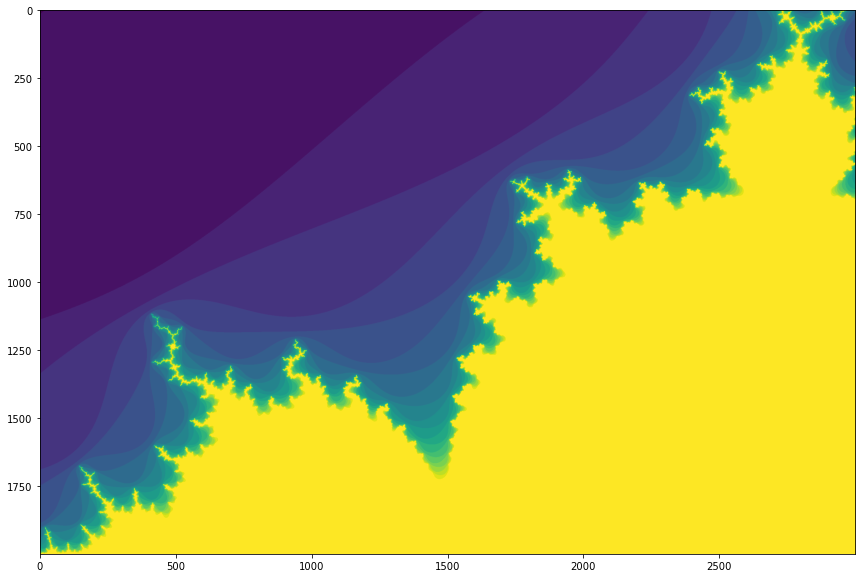

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.imshow(run_numpy(2000, 3000));

In [8]:
%%timeit -o
run_numpy(2000, 3000)

1.44 s ± 36.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.44 s ± 36.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [9]:
result_numpy = _

## pybind11: imperative in C++

In [10]:
%%writefile run_pybind11.cpp
#include <complex>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
namespace py = pybind11;
void run(int height, int width, int maxiterations,
         py::array_t<std::complex<double>> np_c, py::array_t<int> np_fractal) {
    std::complex<double>* c = static_cast<std::complex<double>*>(np_c.request().ptr);
    int* fractal = static_cast<int*>(np_fractal.request().ptr);
    for (int h = 0;  h < height;  h++) {
        for (int w = 0;  w < width;  w++) {
            std::complex<double> ci = c[h + height*w];
            std::complex<double> z = ci;
            for (int i = 0;  i < maxiterations;  i++) {
                z = z*z + ci;
                if (std::abs(z) > 2) {
                    fractal[h + height*w] = i;
                    break;
}}}}}
PYBIND11_MODULE(run_pybind11, m) {
    m.def("run", &run, "the inner loop");
}

Overwriting run_pybind11.cpp


In [11]:
!pip install pybind11

In [12]:
%%bash

export PYTHON_CONFIG=`which python-config python3-config | head -n1`

c++ -Wall -shared -std=c++11 -fPIC -O3 `python -m pybind11 --includes` run_pybind11.cpp -o run_pybind11`$PYTHON_CONFIG --extension-suffix`

In [13]:
import run_pybind11

def run_c_plus_plus(height, width, maxiterations=20):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.full(c.shape, maxiterations, dtype=np.int32)
    run_pybind11.run(height, width, maxiterations, c, fractal)
    return fractal

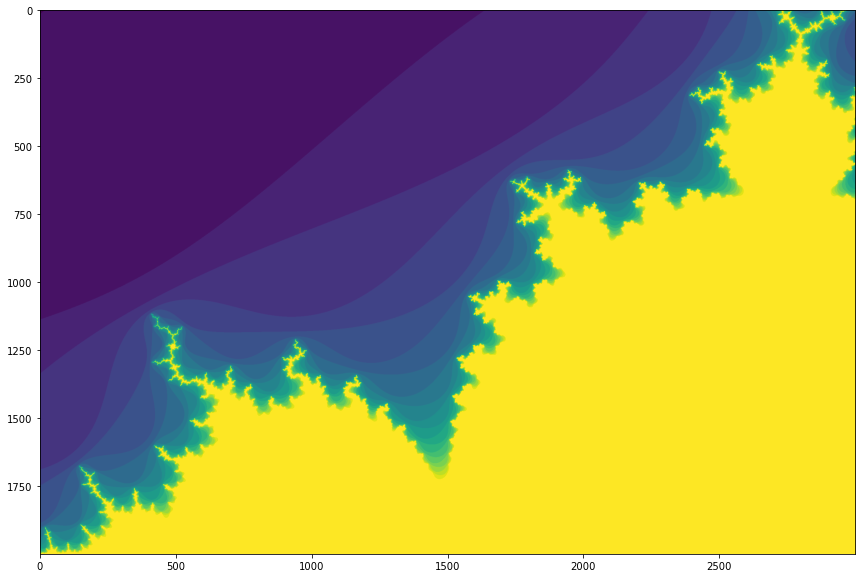

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_c_plus_plus(2000, 3000));

In [15]:
%%timeit -o
run_c_plus_plus(2000, 3000)

468 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 468 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [16]:
result_c_plus_plus = _

## Cython: imperative in a C++/Python hybrid

In [17]:
%load_ext Cython

In [18]:
%%cython --cplus -c-O3 -c-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION
import cython
import numpy as np         # load Python interface to Numpy
cimport numpy as np        # load C++ interface to Numpy (types end in _t)

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping (e.g. -1 for last element)
def run_cython(int height, int width, int maxiterations=20):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.zeros(c.shape, dtype=np.int32) + maxiterations
    cdef np.ndarray[np.complex128_t, ndim=2, mode="c"] c_array = c
    cdef np.ndarray[np.int32_t,      ndim=2, mode="c"] fractal_array = fractal
    cdef np.complex128_t z
    for h in range(height):
        for w in range(width):
            z = c_array[h, w]
            for i in range(maxiterations):
                z = z * z + c_array[h, w]     # z**2 → z * z is a 10× speedup
                if abs(z) > 2:
                    fractal_array[h, w] = i
                    break
    return fractal

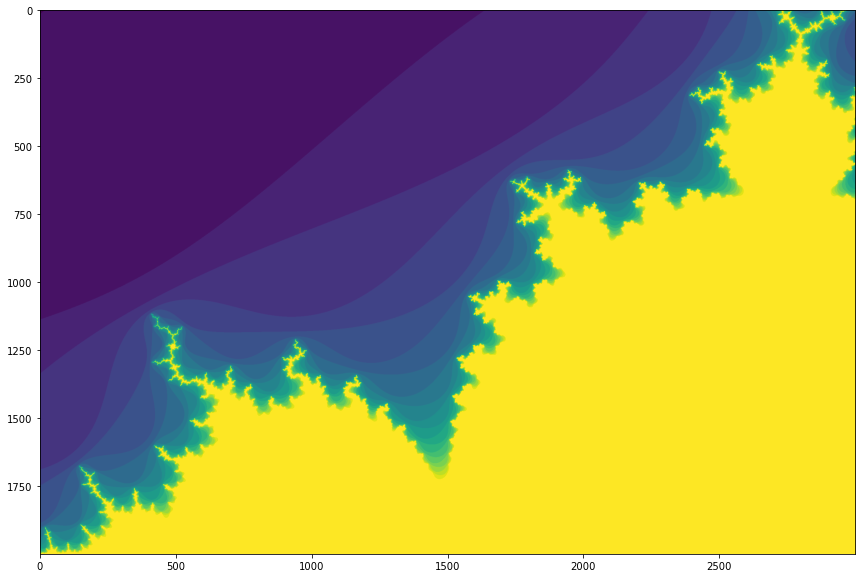

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_cython(2000, 3000));

In [20]:
%%timeit -o
run_cython(2000, 3000)

465 ms ± 9.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 465 ms ± 9.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [21]:
result_cython = _

## Numba: imperative in a compiled subset of Python

In [22]:
import numba as nb

def run_numba(height, width, maxiterations=20):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    return numba_inner_loop(height, width, maxiterations, x, y)

@nb.njit
def numba_inner_loop(height, width, maxiterations, x, y):
    c = x + y*1j
    fractal = np.full(c.shape, maxiterations, dtype=np.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

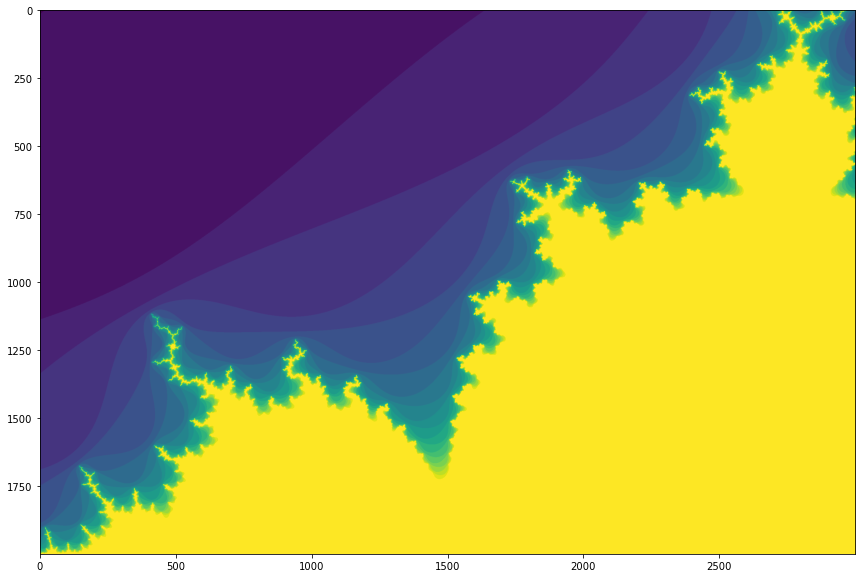

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.imshow(run_numba(2000, 3000));

In [24]:
%%timeit -o
run_numba(2000, 3000)

448 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 448 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [25]:
result_numba = _

## Numba vectorize: imperative per pixel, array-oriented in the large

In [26]:
@nb.vectorize
def fractal_ufunc(ci, maxiterations=20):
    z = ci
    for i in range(maxiterations):
        z = z**2 + ci
        if abs(z) > 2:
            return i
    return maxiterations

def run_numba_custom_ufunc(height, width, maxiterations=20):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    return fractal_ufunc(c, maxiterations)

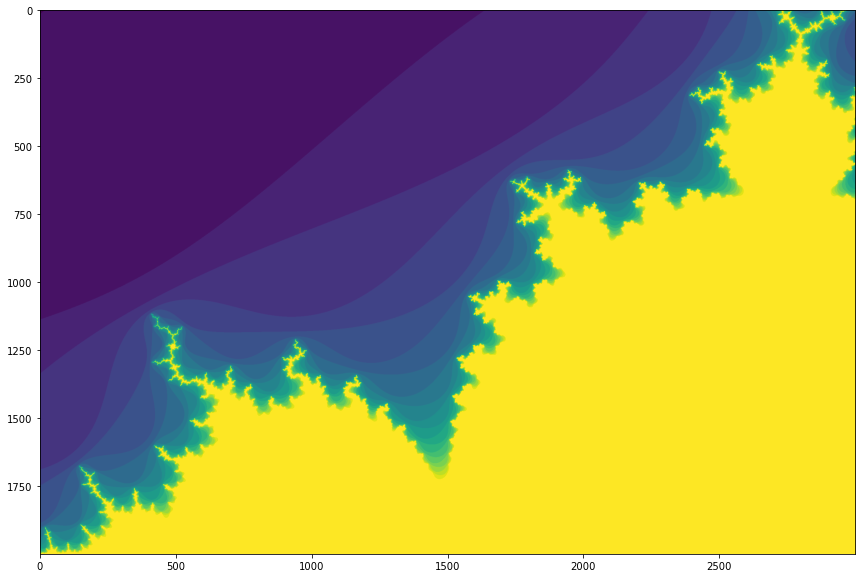

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.imshow(run_numba_custom_ufunc(2000, 3000));

In [28]:
%%timeit -o
run_numba_custom_ufunc(2000, 3000)

448 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 448 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [29]:
result_numba_custom_ufunc = _

## CuPy: array-oriented on a GPU

In [30]:
import cupy as cp

def run_cupy(height, width, maxiterations=20):
    y, x = cp.ogrid[-1:0:height*1j, -1.5:0:width*1j]               # <--- changed this line from the NumPy version
    c = x + y*1j
    fractal = cp.full(c.shape, maxiterations, dtype=np.int32)      # <--- changed this line from the NumPy version
    z = c
    two = cp.array(2)                                              # <--- don't use Python numbers; use CuPy zero-dimensional arrays
    i_array = cp.arange(maxiterations)                             # <--- here, too
    for i in i_array:
        z = z * z + c                                           # applying z → z² + c
        diverged = np.absolute(z) > two                         # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = two                                       # clamp diverged at 2
    return fractal.get()

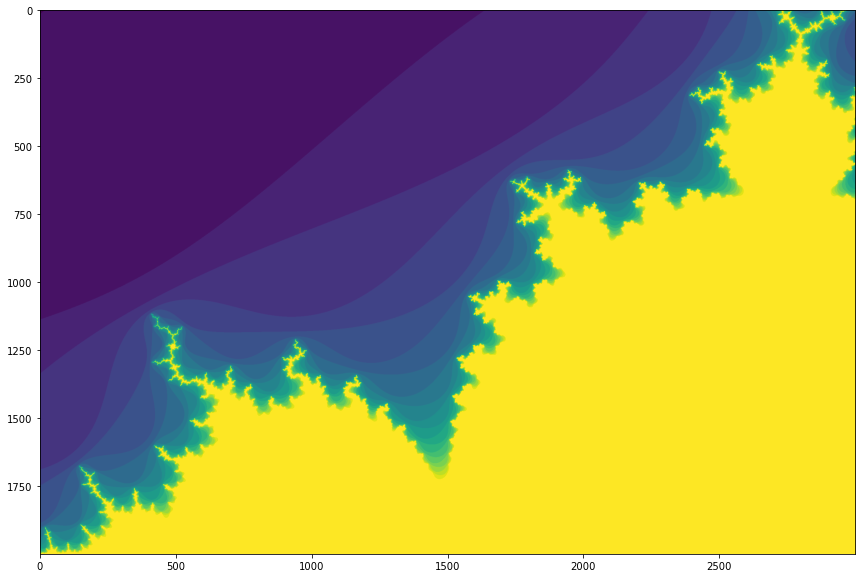

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_cupy(2000, 3000));

In [32]:
%%timeit -o
run_cupy(2000, 3000)

77.8 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 77.8 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [33]:
result_cupy = _

## CuPy with a custom kernel: imperative per pixel, array-oriented in the large

In [34]:
cupy_custom_kernel = cp.RawKernel("""
#include <cupy/complex.cuh>

extern "C" __global__
void cupy_custom_kernel(int height, int width, int maxiterations, int* fractal) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    complex<double> j(0.0, 1.0);
    complex<double> z, c;
    z = c = complex<double>(-1.5 + y*1.0/(height + 1)) - j + complex<double>(x*1.5)*j/complex<double>(width + 1);

    fractal[y + x*width] = maxiterations;
    for (int i = 0;  i < maxiterations;  i++) {
        z = z * z + c;
        if (abs(z) > 2) {
            fractal[y + x*width] = i;
            break;
        }
    }
}
""", "cupy_custom_kernel")

def run_cupy_custom_kernel(height, width, maxiterations=20):
    fractal = cp.empty((height, width), dtype=np.int32)
    griddim = (math.ceil(height / 32), math.ceil(width / 32))
    blockdim = (32, 32)
    cupy_custom_kernel(griddim, blockdim, (height, width, maxiterations, fractal))
    return fractal.get()

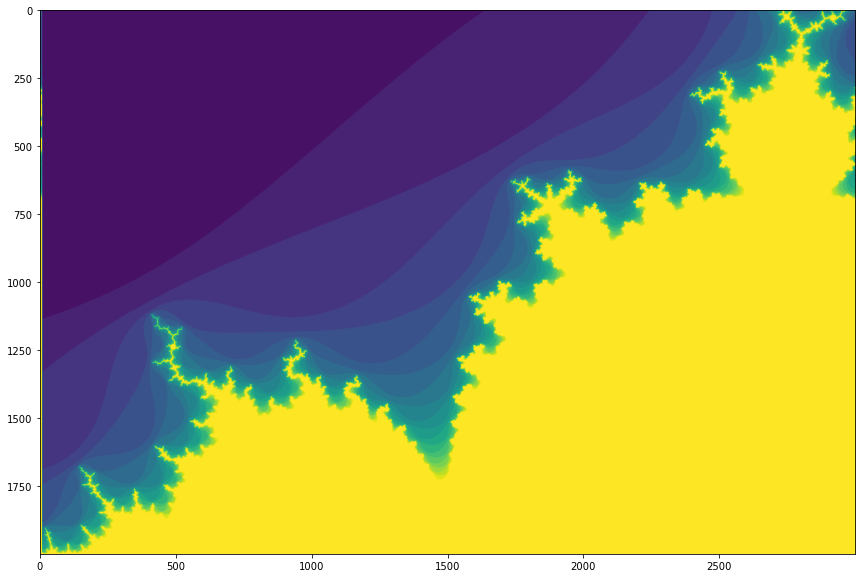

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_cupy_custom_kernel(2000, 3000));

In [36]:
%%timeit -o
run_cupy_custom_kernel(2000, 3000)

22.1 ms ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 22.1 ms ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [37]:
result_cupy_custom_kernel = _

## Numba-CUDA: imperative per pixel, array-oriented in the large

In [38]:
import numba.cuda

@nb.cuda.jit
def one_pixel_numba_cuda(height, width, maxiterations, fractal):
    x, y = nb.cuda.grid(2)              # 2-dimensional CUDA grid
    z = c = -1.5 + y*1.0/(height + 1) + -1j + x*1j*1.5/(width + 1)
    fractal[x, y] = maxiterations
    for i in range(maxiterations):      # iterate at most 20 times
        z = z * z + c                   # applying z → z² + c
        if abs(z) > 2:                  # if it diverges (|z| > 2)
            fractal[x, y] = i           # color the plane with the iteration number
            break                       # we're done, no need to keep iterating

def run_numba_cuda(height, width, maxiterations=20):
    fractal = cp.empty((height, width), dtype=np.int32)
    griddim = (math.ceil(height / 32), math.ceil(width / 32))
    blockdim = (32, 32)
    one_pixel_numba_cuda[griddim, blockdim](height, width, maxiterations, fractal)
    return fractal.get()

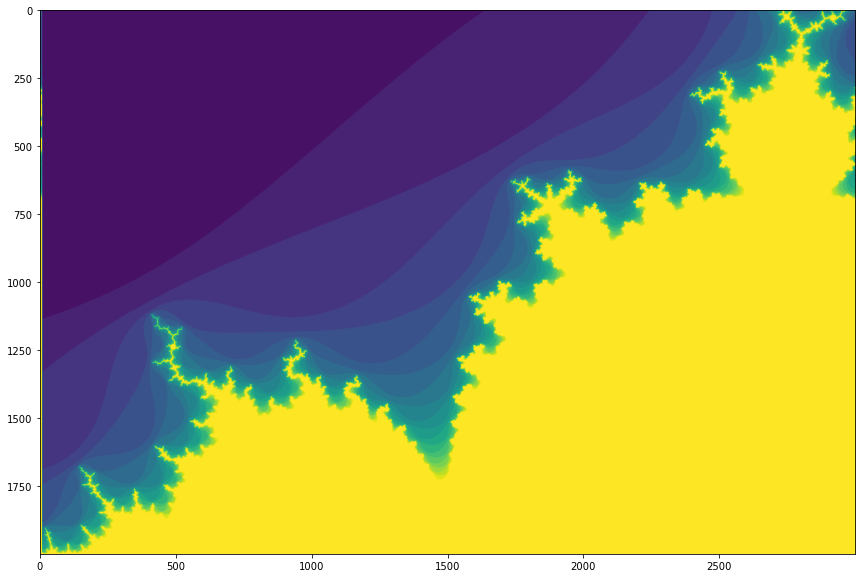

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(run_numba_cuda(2000, 3000));

In [40]:
%%timeit -o
run_numba_cuda(2000, 3000)

23.8 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 23.8 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [41]:
result_numba_cuda = _

## Summary (of a run on Google Colab with GPU)

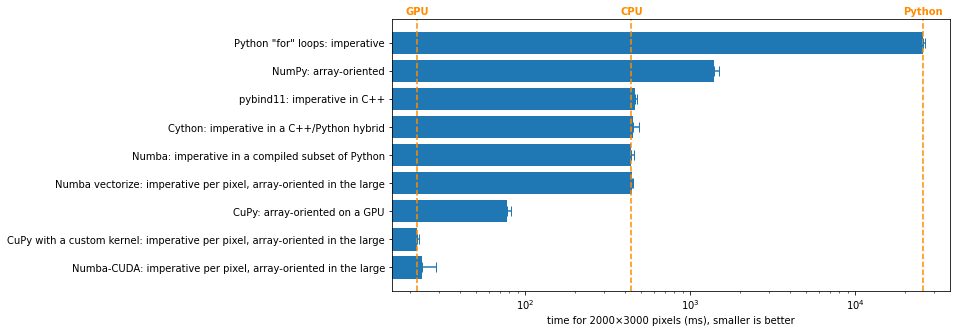

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))

test_names = [
    'Python "for" loops: imperative',
    'NumPy: array-oriented',
    'pybind11: imperative in C++',
    'Cython: imperative in a C++/Python hybrid',
    'Numba: imperative in a compiled subset of Python',
    'Numba vectorize: imperative per pixel, array-oriented in the large',
    'CuPy: array-oriented on a GPU',
    'CuPy with a custom kernel: imperative per pixel, array-oriented in the large',
    'Numba-CUDA: imperative per pixel, array-oriented in the large',
][::-1]
test_results = np.array([
    1e3 * 100 * result_python.best,
    1e3 * result_numpy.best,
    1e3 * result_c_plus_plus.best,
    1e3 * result_cython.best,
    1e3 * result_numba.best,
    1e3 * result_numba_custom_ufunc.best,
    1e3 * result_cupy.best,
    1e3 * result_cupy_custom_kernel.best,
    1e3 * result_numba_cuda.best,
][::-1])
test_variations = np.array([
    1e3 * 100 * np.ptp(result_python.all_runs),
    1e3 * np.ptp(result_numpy.all_runs),
    1e3 * np.ptp(result_c_plus_plus.all_runs),
    1e3 * np.ptp(result_cython.all_runs),
    1e3 * np.ptp(result_numba.all_runs),
    1e3 * np.ptp(result_numba_custom_ufunc.all_runs),
    1e3 * np.ptp(result_cupy.all_runs),
    1e3 * np.ptp(result_cupy_custom_kernel.all_runs),
    1e3 * np.ptp(result_numba_cuda.all_runs),
][::-1])

ax.axvline(test_results[1], c="darkorange", ls="--");
ax.axvline(test_results[4], c="darkorange", ls="--");
ax.axvline(test_results[8], c="darkorange", ls="--");
ax.text(test_results[1], len(test_results), "GPU", ha="center", c="darkorange", weight="bold");
ax.text(test_results[4], len(test_results), "CPU", ha="center", c="darkorange", weight="bold");
ax.text(test_results[8], len(test_results), "Python", ha="center", c="darkorange", weight="bold");
ax.barh(range(len(test_names)), test_results);
ax.errorbar(test_results + test_variations/2, range(len(test_names)), xerr=test_variations/2, capsize=5, fmt="none", c="#1f77b4");
ax.set_yticks(range(len(test_names)));
ax.set_yticklabels(test_names);
ax.set_xlabel("time for 2000×3000 pixels (ms), smaller is better");
ax.set_xscale("log");